In [2]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from pathlib import Path
%matplotlib inline
import xgboost as xgb

## DATA

In [35]:
PATH = Path("./../data")

In [36]:
df = pd.read_csv(PATH/'SolarPrediction.csv', infer_datetime_format=True, parse_dates=[1,])
#dataset = dataset.sort_values(['UNIXTime'], ascending = [True])
df.head()

UNIXTime       Data      Time  Radiation  Temperature  Pressure  \
0  1475229326 2016-09-29  23:55:26       1.21           48     30.46   
1  1475229023 2016-09-29  23:50:23       1.21           48     30.46   
2  1475228726 2016-09-29  23:45:26       1.23           48     30.46   
3  1475228421 2016-09-29  23:40:21       1.21           48     30.46   
4  1475228124 2016-09-29  23:35:24       1.17           48     30.46   

   Humidity  WindDirection(Degrees)  Speed TimeSunRise TimeSunSet  
0        59                  177.39   5.62    06:13:00   18:13:00  
1        58                  176.78   3.37    06:13:00   18:13:00  
2        57                  158.75   3.37    06:13:00   18:13:00  
3        60                  137.71   3.37    06:13:00   18:13:00  
4        62                  104.95   5.62    06:13:00   18:13:00

In [13]:
df.Data

0       2016-09-29
1       2016-09-29
2       2016-09-29
3       2016-09-29
4       2016-09-29
           ...    
32681   2016-12-01
32682   2016-12-01
32683   2016-12-01
32684   2016-12-01
32685   2016-12-01
Name: Data, Length: 32686, dtype: datetime64[ns]

In [14]:
df['Data']

0       2016-09-29
1       2016-09-29
2       2016-09-29
3       2016-09-29
4       2016-09-29
           ...    
32681   2016-12-01
32682   2016-12-01
32683   2016-12-01
32684   2016-12-01
32685   2016-12-01
Name: Data, Length: 32686, dtype: datetime64[ns]

In [15]:
# Convert all dates and times to unix timestamp (timezone doesn't matter now)
df['Data'] = df['Data'].dt.date.astype(str)
df['TimeSunRise'] = df['Data'] + ' ' + df['TimeSunRise']
df['TimeSunSet'] = df['Data'] + ' ' + df['TimeSunSet']
df['Data'] = df['Data'] + ' ' + df['Time']

# Convert to Unix timestamp
fields = ['Data', 'TimeSunRise', 'TimeSunSet']
for x in fields:
    df[x + '_UnixTimeStamp'] = df[x].apply(
        lambda k: int(datetime.strptime(k, "%Y-%m-%d %H:%M:%S").timestamp())
    )

# New sun time field
df['SunTime'] = df['TimeSunSet_UnixTimeStamp'] - df['TimeSunRise_UnixTimeStamp']

# Drop old columns
df.drop('UNIXTime', axis=1, inplace=True)
df.drop('Data', axis=1, inplace=True)
df.drop('Time', axis=1, inplace=True)
df.drop('TimeSunRise', axis=1, inplace=True)
df.drop('TimeSunSet', axis=1, inplace=True)



In [16]:
df

Radiation  Temperature  Pressure  Humidity  WindDirection(Degrees)  \
0           1.21           48     30.46        59                  177.39   
1           1.21           48     30.46        58                  176.78   
2           1.23           48     30.46        57                  158.75   
3           1.21           48     30.46        60                  137.71   
4           1.17           48     30.46        62                  104.95   
...          ...          ...       ...       ...                     ...   
32681       1.22           44     30.43       102                  145.42   
32682       1.17           44     30.42       102                  117.78   
32683       1.20           44     30.42       102                  145.19   
32684       1.23           44     30.42       101                  164.19   
32685       1.20           44     30.43       101                   83.59   

       Speed  Data_UnixTimeStamp  TimeSunRise_UnixTimeStamp  \
0       5.62          1475173526                 1475109780   
1       3.37          1475173223                 1475109780   
2       3.37          1475172926                 1475109780   
3       3.37          1475172621                 1475109780   
4       5.62          1475172324                 1475109780   
...      ...                 ...                        ...   
32681   6.75          1480531804                 1480554660   
32682   6.75          1480531501                 1480554660   
32683   9.00          1480531201                 1480554660   
32684   7.87          1480530902                 1480554660   
32685   3.37          1480530602                 1480554660   

       TimeSunSet_UnixTimeStamp  SunTime  
0                    1475152980    43200  
1                    1475152980    43200  
2                    1475152980    43200  
3                    1475152980    43200  
4                    1475152980    43200  
...                         ...      ...  
32681                1480594320    39660  
32682                1480594320    39660  
32683                1480594320    39660  
32684                1480594320    39660  
32685                1480594320    39660  

[32686 rows x 10 columns]

In [17]:
def dddraw(X_reduced,name):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    # To getter a better understanding of interaction of the dimensions
    # plot the first three PCA dimensions
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,cmap=plt.cm.Paired)
    titel="First three directions of "+name 
    ax.set_title(titel)
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])

    plt.show()

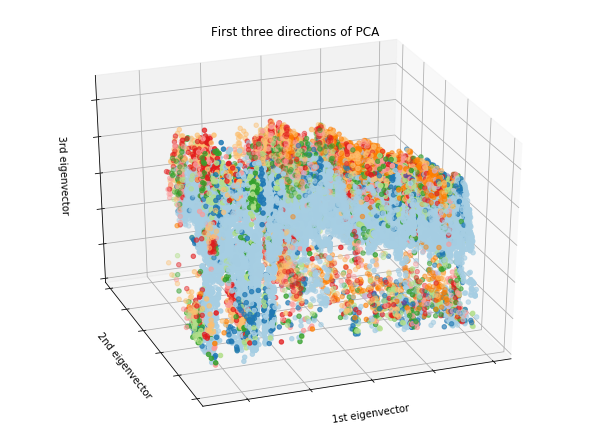

C:\Users\Abhij\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log1p
  


PCA %error 68.6 rmsle 2.4883648807690806


C:\Users\Abhij\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


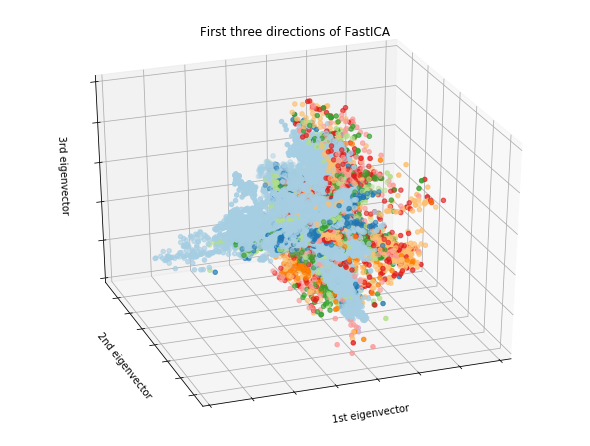

C:\Users\Abhij\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log1p
  


FastICA %error 68.6 rmsle 2.487253014451459


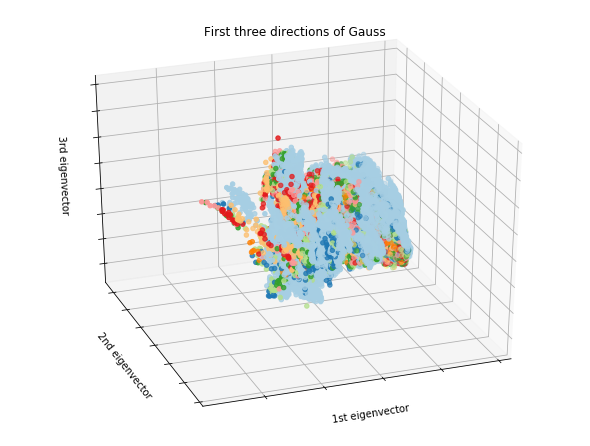

C:\Users\Abhij\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log1p
  


Gauss %error 103.7 rmsle 2.8940533920305738


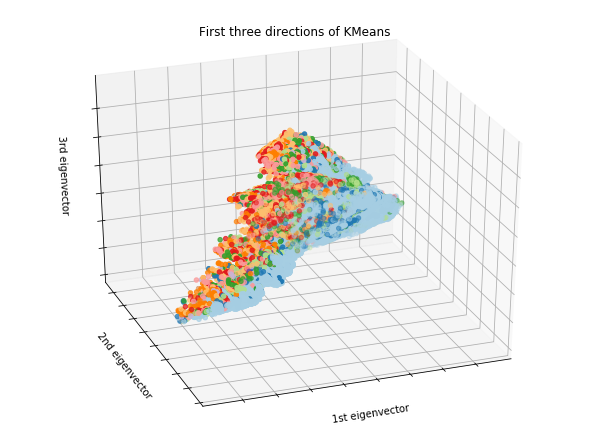

C:\Users\Abhij\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log1p
  


KMeans %error 64.7 rmsle 2.4255007414683885


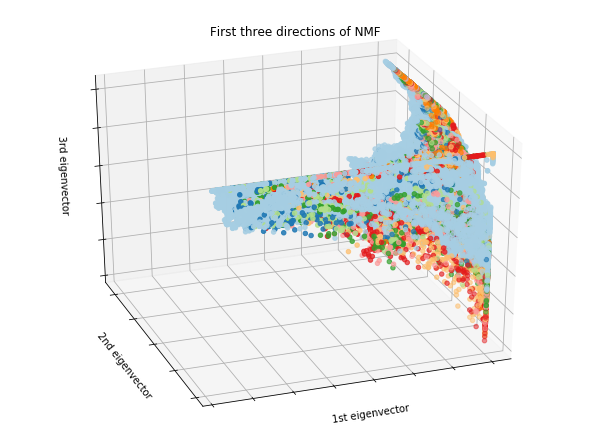

NMF %error 69.5 rmsle 2.512407508527649


C:\Users\Abhij\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log1p
  


In [21]:
from sklearn.decomposition import PCA, FastICA,SparsePCA,NMF, LatentDirichletAllocation,FactorAnalysis
from sklearn.random_projection import GaussianRandomProjection,SparseRandomProjection
from sklearn.cluster import KMeans,Birch
import statsmodels.formula.api as sm
from scipy import linalg
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
import matplotlib.pyplot as plt

n_col=12
X = df.drop('Radiation',axis=1) # we only take the first two features.

def rmsle(y_predicted, y_real):
    return np.sqrt(np.mean(np.power(np.log1p(y_predicted)-np.log1p(y_real), 2)))
def procenterror(y_predicted, y_real):
     return np.round( np.mean(np.abs(y_predicted-y_real) )/ np.mean(y_real) *100 ,1)

    
Y=df['Radiation']
scaler = MinMaxScaler()
scaler.fit(X)
X=scaler.transform(X)
poly = PolynomialFeatures(2)
X=poly.fit_transform(X)



names = [
         'PCA',
         'FastICA',
         'Gauss',
         'KMeans',
         #'SparsePCA',
         #'SparseRP',
         #'Birch',
         'NMF',    
         #'LatentDietrich',    
        ]

classifiers = [
    
    PCA(n_components=n_col),
    FastICA(n_components=n_col),
    GaussianRandomProjection(n_components=3),
    KMeans(n_clusters=24),
    #SparsePCA(n_components=n_col),
    #SparseRandomProjection(n_components=n_col, dense_output=True),
    #Birch(branching_factor=10, n_clusters=12, threshold=0.5),
    NMF(n_components=n_col),    
    #LatentDirichletAllocation(n_topics=n_col),
    
]
correction= [1,1,0,0,0,0,0,0,0]

temp=zip(names,classifiers,correction)
print(temp)
import statsmodels.regression.linear_model as sm
for name, clf,correct in temp:
    Xr=clf.fit_transform(X,Y)
    dddraw(Xr,name)
    res = sm.OLS(Y,Xr).fit()
    #print(res.summary())  # show OLS regression
    #print(res.predict(Xr).round()+correct)  #show OLS prediction
    #print('Ypredict',res.predict(Xr).round()+correct)  #show OLS prediction

    #print('Ypredict *log_sec',res.predict(Xr).round()+correct*Y.mean())  #show OLS prediction
    print(name,'%error',procenterror(res.predict(Xr)+correct*Y.mean(),Y),'rmsle',rmsle(res.predict(Xr)+correct*Y.mean(),Y))

In [22]:
from sklearn.linear_model import OrthogonalMatchingPursuit,RANSACRegressor,LogisticRegression,ElasticNetCV,HuberRegressor, Ridge, Lasso,LassoCV,Lars,BayesianRidge,SGDClassifier,LogisticRegressionCV,RidgeClassifier
from sklearn.preprocessing import MinMaxScaler

# import some data to play with
       # those ? converted to NAN are bothering me abit...        

from sklearn.linear_model import OrthogonalMatchingPursuit,RANSACRegressor,LogisticRegression,ElasticNetCV,HuberRegressor, Ridge, Lasso,LassoCV,Lars,BayesianRidge,SGDClassifier,LogisticRegressionCV,RidgeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

X = df.drop('Radiation',axis=1) # we only take the first two features.
le = preprocessing.LabelEncoder()
def rmsle(y_predicted, y_real):
    return np.sqrt(np.mean(np.power(np.log1p(y_predicted)-np.log1p(y_real), 2)))
def procenterror(y_predicted, y_real):
     return np.round( np.mean(np.abs(y_predicted-y_real) )/ np.mean(y_real) *100 ,1)

    
Y=np.round(np.log(df['Radiation'])*10)
scaler = MinMaxScaler()
scaler.fit(X)
X=scaler.transform(X)
poly = PolynomialFeatures(2)
X=poly.fit_transform(X)


names = [
         #'ElasticNet',
         #'SVC',
         #'kSVC',
         'KNN',
         'DecisionTree',
         'RandomForestClassifier',
         #'GridSearchCV',
         #'HuberRegressor',
         #'Ridge',
         #'Lasso',
         #'LassoCV',
         #'Lars',
         #'BayesianRidge',
         #'SGDClassifier',
         #'RidgeClassifier',
         #'LogisticRegression',
         #'OrthogonalMatchingPursuit',
         #'RANSACRegressor',
         ]

classifiers = [
    #ElasticNetCV(cv=10, random_state=0),
    #SVC(),
    #SVC(kernel = 'rbf', random_state = 0),
    KNeighborsClassifier(n_neighbors = 1),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators = 200),
    #GridSearchCV(SVC(),param_grid, refit = True, verbose = 1),
    HuberRegressor(fit_intercept=True, alpha=0.0, max_iter=100,epsilon=2.95),
    Ridge(fit_intercept=True, alpha=0.0, random_state=0, normalize=True),
    Lasso(alpha=0.05),
    LassoCV(),
    Lars(n_nonzero_coefs=10),
    BayesianRidge(),
    SGDClassifier(),
    RidgeClassifier(),
    LogisticRegression(),
    OrthogonalMatchingPursuit(),
    #RANSACRegressor(),
]
correction= [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

temp=zip(names,classifiers,correction)
print(temp)

for name, clf,correct in temp:
    regr=clf.fit(X,Y)
    #print( name,'% errors', abs(regr.predict(X)+correct-Y).sum()/(Y.sum())*100)
    print(name,'%error',procenterror(regr.predict(X),Y),'rmsle',rmsle(regr.predict(X),Y))
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score

    # Confusion Matrix
    print(name,'Confusion Matrix')
    print(confusion_matrix(Y, np.round(regr.predict(X) ) ) )
    print('--'*40)

    # Classification Report
    print('Classification Report')
    print(classification_report(Y,np.round( regr.predict(X) ) ))

    # Accuracy
    print('--'*40)
    logreg_accuracy = round(accuracy_score(Y, np.round( regr.predict(X) ) ) * 100,2)
    print('Accuracy', logreg_accuracy,'%')
    df[name]=regr.predict(X)

KNN %error 0.0 rmsle 0.0
KNN Confusion Matrix
[[  126     0     0 ...     0     0     0]
 [    0 14024     0 ...     0     0     0]
 [    0     0   673 ...     0     0     0]
 ...
 [    0     0     0 ...    15     0     0]
 [    0     0     0 ...     0     4     0]
 [    0     0     0 ...     0     0     1]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       126
         2.0       1.00      1.00      1.00     14024
         3.0       1.00      1.00      1.00       673
         4.0       1.00      1.00      1.00       132
         5.0       1.00      1.00      1.00       191
         6.0       1.00      1.00      1.00       198
         7.0       1.00      1.00      1.00       291
         8.0       1.00      1.00      1.00       295
         9.0       1.00      1.00      1.00       331
        10.0       1.00      1.00      1.00   

RandomForestClassifier %error 0.0 rmsle 0.0
RandomForestClassifier Confusion Matrix
[[  126     0     0 ...     0     0     0]
 [    0 14024     0 ...     0     0     0]
 [    0     0   673 ...     0     0     0]
 ...
 [    0     0     0 ...    15     0     0]
 [    0     0     0 ...     0     4     0]
 [    0     0     0 ...     0     0     1]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       126
         2.0       1.00      1.00      1.00     14024
         3.0       1.00      1.00      1.00       673
         4.0       1.00      1.00      1.00       132
         5.0       1.00      1.00      1.00       191
         6.0       1.00      1.00      1.00       198
         7.0       1.00      1.00      1.00       291
         8.0       1.00      1.00      1.00       295
         9.0       1.00      1.00      1.00       331
        

In [23]:
# Create the K-folds
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle = True)

# Prepare dataset
X = df.drop(['Radiation','Data_UnixTimeStamp','TimeSunRise_UnixTimeStamp','TimeSunSet_UnixTimeStamp'] , axis=1).as_matrix()
y = df['Radiation'].as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

C:\Users\Abhij\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Abhij\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [25]:
xgb_params = {
    'n_trees': 50, 
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

[0]	train-rmse:359.372	test-rmse:359.36
[200]	train-rmse:9.46936	test-rmse:10.6365


<Figure size 2400x1600 with 0 Axes>

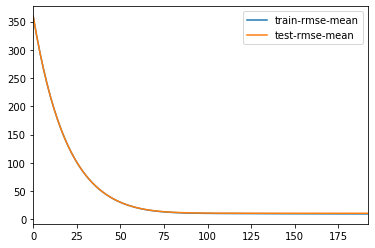

In [34]:
plt.figure(dpi=400)
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=50,
    verbose_eval=200, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
#plt.show()

In [27]:
num_boost_rounds = len(cv_output)
print(num_boost_rounds)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

193
[17:03:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [28]:
from sklearn.metrics import r2_score
print("R^2 in training: %s"  % r2_score(dtrain.get_label(), model.predict(dtrain)))
print("R^2 in testing: %s"  % r2_score(y_test, model.predict(dtest)))

R^2 in training: 0.9990496011437123
R^2 in testing: 0.9989031498475649


In [32]:
df

Radiation  Temperature  Pressure  Humidity  WindDirection(Degrees)  \
0           1.21           48     30.46        59                  177.39   
1           1.21           48     30.46        58                  176.78   
2           1.23           48     30.46        57                  158.75   
3           1.21           48     30.46        60                  137.71   
4           1.17           48     30.46        62                  104.95   
...          ...          ...       ...       ...                     ...   
32681       1.22           44     30.43       102                  145.42   
32682       1.17           44     30.42       102                  117.78   
32683       1.20           44     30.42       102                  145.19   
32684       1.23           44     30.42       101                  164.19   
32685       1.20           44     30.43       101                   83.59   

       Speed  Data_UnixTimeStamp  TimeSunRise_UnixTimeStamp  \
0       5.62          1475173526                 1475109780   
1       3.37          1475173223                 1475109780   
2       3.37          1475172926                 1475109780   
3       3.37          1475172621                 1475109780   
4       5.62          1475172324                 1475109780   
...      ...                 ...                        ...   
32681   6.75          1480531804                 1480554660   
32682   6.75          1480531501                 1480554660   
32683   9.00          1480531201                 1480554660   
32684   7.87          1480530902                 1480554660   
32685   3.37          1480530602                 1480554660   

       TimeSunSet_UnixTimeStamp  SunTime  KNN  DecisionTree  \
0                    1475152980    43200  2.0           2.0   
1                    1475152980    43200  2.0           2.0   
2                    1475152980    43200  2.0           2.0   
3                    1475152980    43200  2.0           2.0   
4                    1475152980    43200  2.0           2.0   
...                         ...      ...  ...           ...   
32681                1480594320    39660  2.0           2.0   
32682                1480594320    39660  2.0           2.0   
32683                1480594320    39660  2.0           2.0   
32684                1480594320    39660  2.0           2.0   
32685                1480594320    39660  2.0           2.0   

       RandomForestClassifier  
0                         2.0  
1                         2.0  
2                         2.0  
3                         2.0  
4                         2.0  
...                       ...  
32681                     2.0  
32682                     2.0  
32683                     2.0  
32684                     2.0  
32685                     2.0  

[32686 rows x 13 columns]